Sun Han Milestone 5

In [204]:
import pandas as pd
import numpy as np
import seaborn as sns
import xgboost as xgb
import matplotlib.pyplot as plt
import warnings
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import StackingClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import (
    mean_squared_error, roc_curve, auc, 
    precision_recall_curve, precision_score, 
    f1_score, recall_score, confusion_matrix
)

warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings("ignore", message="Parameters: { \"use_label_encoder\" } are not used.")

# Load the file
file_path = "C:/Users/sunwo/Desktop/School/Spring 2025/DSC630-T301 Predictive Analytics (2255-1)/Final Project/carclaims.csv"  
data = pd.read_csv(file_path)

# Display the data
print(data.head(2))

  Month  WeekOfMonth  DayOfWeek   Make AccidentArea DayOfWeekClaimed  \
0   Dec            5  Wednesday  Honda        Urban          Tuesday   
1   Jan            3  Wednesday  Honda        Urban           Monday   

  MonthClaimed  WeekOfMonthClaimed     Sex MaritalStatus  ...  \
0          Jan                   1  Female        Single  ...   
1          Jan                   4    Male        Single  ...   

   AgeOfPolicyHolder PoliceReportFiled WitnessPresent AgentType  \
0           26 to 30                No             No  External   
1           31 to 35               Yes             No  External   

  NumberOfSuppliments  AddressChange-Claim  NumberOfCars  Year  BasePolicy  \
0                none               1 year        3 to 4  1994   Liability   
1                none            no change     1 vehicle  1994   Collision   

  FraudFound  
0         No  
1         No  

[2 rows x 33 columns]


In [205]:
# Checking for missing values
missing_values = data.isnull().sum()

print("Missing values per column:")
print(missing_values[missing_values > 0])

Missing values per column:
Series([], dtype: int64)


Knowing the unique values helps in detecting anomalies, inconsistencies (like typos), or data encoding issues (e.g., "Yes" vs "yes").

In [207]:
# Inspect unique values in object columns
object_cols = data.select_dtypes(include='object').columns
for col in object_cols:
    print(f"{col}: {data[col].unique()}")

Month: ['Dec' 'Jan' 'Oct' 'Jun' 'Feb' 'Nov' 'Apr' 'Mar' 'Aug' 'Jul' 'May' 'Sep']
DayOfWeek: ['Wednesday' 'Friday' 'Saturday' 'Monday' 'Tuesday' 'Sunday' 'Thursday']
Make: ['Honda' 'Toyota' 'Ford' 'Mazda' 'Chevrolet' 'Pontiac' 'Accura' 'Dodge'
 'Mercury' 'Jaguar' 'Nisson' 'VW' 'Saab' 'Saturn' 'Porche' 'BMW' 'Mecedes'
 'Ferrari' 'Lexus']
AccidentArea: ['Urban' 'Rural']
DayOfWeekClaimed: ['Tuesday' 'Monday' 'Thursday' 'Friday' 'Wednesday' 'Saturday' 'Sunday'
 '0']
MonthClaimed: ['Jan' 'Nov' 'Jul' 'Feb' 'Mar' 'Dec' 'Apr' 'Aug' 'May' 'Jun' 'Sep' 'Oct'
 '0']
Sex: ['Female' 'Male']
MaritalStatus: ['Single' 'Married' 'Widow' 'Divorced']
Fault: ['Policy Holder' 'Third Party']
PolicyType: ['Sport - Liability' 'Sport - Collision' 'Sedan - Liability'
 'Utility - All Perils' 'Sedan - All Perils' 'Sedan - Collision'
 'Utility - Collision' 'Utility - Liability' 'Sport - All Perils']
VehicleCategory: ['Sport' 'Utility' 'Sedan']
VehiclePrice: ['more than 69,000' '20,000 to 29,000' '30,000 to 39,000'
 '

Handling missing values by converting placeholders like '0' and 'none' to NaN ensures consistency in machine learning models. Ordinal encoding preserves order in features like age or price ranges, while binary encoding (e.g., 'Yes' to 1, 'No' to 0) improves classification. Defining functions like replace_with_nan and map_ordinal enhances code efficiency, modularity, and readability, simplifying data processing and error handling. This approach will strengthen data quality and support a maintainable machine learning pipeline.

In [209]:
# Replace values ('0' or 'none') with NaN to handle missing data
def replace_with_nan(columns, old_value):
    data[columns] = data[columns].replace(old_value, np.nan)

# Columns where '0' should be treated as missing
replace_zero_cols = ['DayOfWeekClaimed', 'MonthClaimed']
replace_with_nan(replace_zero_cols, '0')

# Columns where 'none' should be treated as missing
replace_none_cols = [
    'Days:Policy-Accident', 'Days:Policy-Claim',
    'PastNumberOfClaims', 'NumberOfSuppliments'
]
replace_with_nan(replace_none_cols, 'none')

# Helper function for mapping ordinal categories to numeric values
def map_ordinal(column, mapping):
    data[column] = data[column].map(mapping).fillna(np.nan)

# Mapping ordinal values to numeric equivalents
# Age of Policy Holder (ordinal)
age_map = {
    '16 to 17': 16.5, '18 to 20': 19, '21 to 25': 23,
    '26 to 30': 28, '31 to 35': 33, '36 to 40': 38,
    '41 to 50': 45, '51 to 65': 58, 'over 65': 70
}
map_ordinal('AgeOfPolicyHolder', age_map)

# Vehicle Price (ordinal)
vehicle_price_map = {
    'less than 20,000': 1, '20,000 to 29,000': 2,
    '30,000 to 39,000': 3, '40,000 to 59,000': 4,
    '60,000 to 69,000': 5, 'more than 69,000': 6
}
map_ordinal('VehiclePrice', vehicle_price_map)

# Days:Policy-Accident (ordinal)
policy_accident_map = {
    '1 to 7': 1, '8 to 15': 2, '15 to 30': 3, 'more than 30': 4
}
map_ordinal('Days:Policy-Accident', policy_accident_map)

# Days:Policy-Claim (ordinal)
policy_claim_map = {
    '8 to 15': 1, '15 to 30': 2, 'more than 30': 3
}
map_ordinal('Days:Policy-Claim', policy_claim_map)

# Past Number of Claims (ordinal)
claims_map = {
    '1': 1, '2 to 4': 3, 'more than 4': 5
}
map_ordinal('PastNumberOfClaims', claims_map)

# Age of Vehicle (ordinal)
age_vehicle_map = {
    'new': 0, '2 years': 2, '3 years': 3, '4 years': 4,
    '5 years': 5, '6 years': 6, '7 years': 7, 'more than 7': 8
}
map_ordinal('AgeOfVehicle', age_vehicle_map)

# Number of Supplements (ordinal)
supplements_map = {
    '1 to 2': 1.5, '3 to 5': 4, 'more than 5': 6
}
map_ordinal('NumberOfSuppliments', supplements_map)

# Number of Cars (ordinal)
num_cars_map = {
    '1 vehicle': 1, '2 vehicles': 2, '3 to 4': 3.5, '5 to 8': 6.5, 'more than 8': 9
}
map_ordinal('NumberOfCars', num_cars_map)

# Address Change-Claim (ordinal)
address_change_map = {
    'under 6 months': 0.5, '1 year': 1, '2 to 3 years': 2.5,
    '4 to 8 years': 6, 'no change': 0
}
map_ordinal('AddressChange-Claim', address_change_map)

# Binary target variable encoding ('Yes' -> 1, 'No' -> 0)
data['FraudFound'] = data['FraudFound'].map({'No': 0, 'Yes': 1}).fillna(np.nan)

# Display a summary to verify transformations
print(data.head(2))
print("\nData types after transformations (horizontal):")
print(pd.DataFrame(data.dtypes).T.rename(index={0: 'dtypes'}))

  Month  WeekOfMonth  DayOfWeek   Make AccidentArea DayOfWeekClaimed  \
0   Dec            5  Wednesday  Honda        Urban          Tuesday   
1   Jan            3  Wednesday  Honda        Urban           Monday   

  MonthClaimed  WeekOfMonthClaimed     Sex MaritalStatus  ...  \
0          Jan                   1  Female        Single  ...   
1          Jan                   4    Male        Single  ...   

   AgeOfPolicyHolder PoliceReportFiled WitnessPresent AgentType  \
0               28.0                No             No  External   
1               33.0               Yes             No  External   

   NumberOfSuppliments  AddressChange-Claim  NumberOfCars  Year  BasePolicy  \
0                  NaN                  1.0           3.5  1994   Liability   
1                  NaN                  0.0           1.0  1994   Collision   

   FraudFound  
0           0  
1           0  

[2 rows x 33 columns]

Data types after transformations (horizontal):
         Month WeekOfMonth D

In [210]:
# Check for Remaining Missing Values (horizontal)
print("Missing values per column (horizontal):")
print(pd.DataFrame(data.isnull().sum()).T.rename(index={0: 'missing'}))

Missing values per column (horizontal):
         Month  WeekOfMonth  DayOfWeek  Make  AccidentArea  DayOfWeekClaimed  \
missing      0            0          0     0             0                 1   

         MonthClaimed  WeekOfMonthClaimed  Sex  MaritalStatus  ...  \
missing             1                   0    0              0  ...   

         AgeOfPolicyHolder  PoliceReportFiled  WitnessPresent  AgentType  \
missing                  0                  0               0          0   

         NumberOfSuppliments  AddressChange-Claim  NumberOfCars  Year  \
missing                 7047                    0             0     0   

         BasePolicy  FraudFound  
missing           0           0  

[1 rows x 33 columns]


Most columns have no missing values, but a few require attention. DayOfWeekClaimed and MonthClaimed each have 1 missing value, while Days:Policy-Accident has 55 and Days:Policy-Claim has 1. PastNumberOfClaims (4,352 missing) and NumberOfSuppliments (7,047 missing) may need further investigation or imputation to maintain data quality and support reliable modeling.

We address missing values based on frequency, using mode imputation for sparsely missing data (DayOfWeekClaimed, MonthClaimed, Days:Policy-Accident, and Days:Policy-Claim) and filling large gaps (PastNumberOfClaims, NumberOfSuppliments) with 0, assuming absence indicates no prior claims. This strategy ensures a consistent, robust dataset for analysis and modeling.

In [213]:
# For small missing value counts — fill with mode
for col in ['DayOfWeekClaimed', 'MonthClaimed', 'Days:Policy-Accident', 'Days:Policy-Claim']:
    mode_val = data[col].mode()[0]
    data[col].fillna(mode_val, inplace=True)

# For PastNumberOfClaims — fill with 0 or a special value (assume no claims if unknown)
data['PastNumberOfClaims'].fillna(0, inplace=True)

# For NumberOfSuppliments — fill with 0 or average value 
data['NumberOfSuppliments'].fillna(0, inplace=True)

In [214]:
# Check for missing values
print("Remaining missing values:\n", data.isnull().sum().sum())

Remaining missing values:
 0


This safeguard ensures dataset completeness throughout preprocessing. Some missing values may be intentional, accidental, or reintroduced during transformations. Filling NaNs with mode for certain columns and 0 for others guarantees fully preprocessed data, preventing issues when models require complete inputs.

In [216]:
# Fill remaining NaNs
data['NumberOfSuppliments'].fillna(0, inplace=True)
data['AddressChange-Claim'].fillna(data['AddressChange-Claim'].mode()[0], inplace=True)
data['Days:Policy-Accident'].fillna(data['Days:Policy-Accident'].mode()[0], inplace=True)
data['Days:Policy-Claim'].fillna(data['Days:Policy-Claim'].mode()[0], inplace=True)
data['PastNumberOfClaims'].fillna(0, inplace=True)

Using the describe() method, we obtain key statistics like count, mean, standard deviation, and quartiles for features such as AgeOfPolicyHolder, VehiclePrice, and PastNumberOfClaims. This helps assess data distribution, identify clusters (e.g., Days:Policy-Accident around 4), and spot outliers (e.g., NumberOfCars mostly 1 with a few higher values). Validating these summaries ensures our transformations align with expectations, preparing the dataset for further analysis.

In [218]:
# Summary Stats for Transformed Columns
cols_to_check = ['AgeOfPolicyHolder', 'VehiclePrice', 'Days:Policy-Accident',
                 'PastNumberOfClaims', 'AgeOfVehicle', 'NumberOfSuppliments',
                 'NumberOfCars', 'AddressChange-Claim']

print(data[cols_to_check].describe().T)

                        count       mean        std   min   25%   50%   75%  \
AgeOfPolicyHolder     15420.0  39.362646  10.076856  16.5  33.0  38.0  45.0   
VehiclePrice          15420.0   2.796109   1.443017   1.0   2.0   2.0   3.0   
Days:Policy-Accident  15420.0   3.986965   0.159524   1.0   4.0   4.0   4.0   
PastNumberOfClaims    15420.0   1.950584   1.699188   0.0   0.0   1.0   3.0   
AgeOfVehicle          15420.0   6.581582   1.501288   0.0   6.0   7.0   8.0   
NumberOfSuppliments   15420.0   2.270006   2.516256   0.0   0.0   1.5   6.0   
NumberOfCars          15420.0   1.114818   0.482791   1.0   1.0   1.0   1.0   
AddressChange-Claim   15420.0   0.303859   1.228803   0.0   0.0   0.0   0.0   

                       max  
AgeOfPolicyHolder     70.0  
VehiclePrice           6.0  
Days:Policy-Accident   4.0  
PastNumberOfClaims     5.0  
AgeOfVehicle           8.0  
NumberOfSuppliments    6.0  
NumberOfCars           9.0  
AddressChange-Claim    6.0  


This code verifies the target variable's encoding by displaying the class distribution in 'FraudFound': 14,497 instances of 0 and 923 of 1. The imbalance suggests potential adjustments like resampling or modified evaluation metrics to improve model performance.

In [220]:
# Confirm Target Variable Encoding
print("Target class distribution:")
print(data['FraudFound'].value_counts())

Target class distribution:
FraudFound
0    14497
1      923
Name: count, dtype: int64


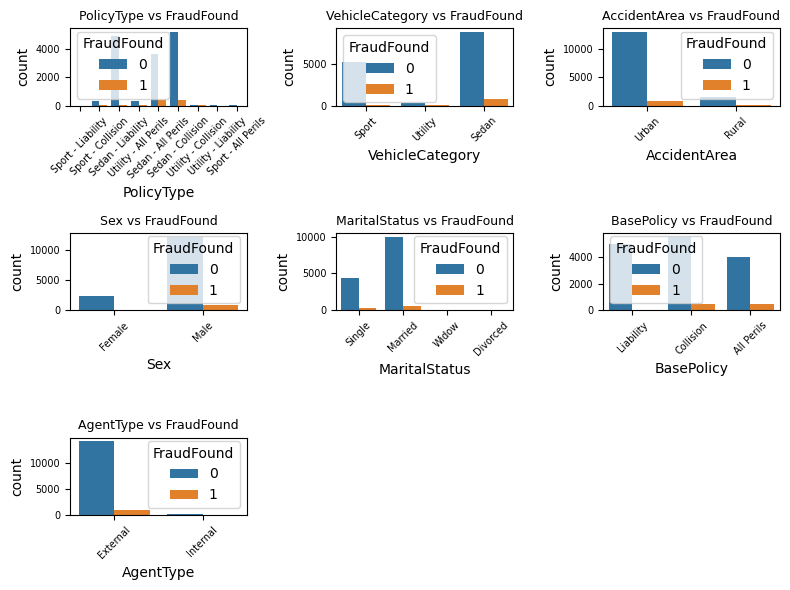

In [221]:
categorical_vars = ['PolicyType', 'VehicleCategory', 'AccidentArea', 
                    'Sex', 'MaritalStatus', 'BasePolicy', 'AgentType']

n_cols = 3
n_rows = -(-len(categorical_vars) // n_cols)  # Ceiling division

# Smaller figsize (width x height), adjust height per row
fig, axes = plt.subplots(n_rows, n_cols, figsize=(8, 2 * n_rows))
axes = axes.flatten()

for i, col in enumerate(categorical_vars):
    sns.countplot(data=data, x=col, hue='FraudFound', ax=axes[i])
    axes[i].set_title(f'{col} vs FraudFound', fontsize=9)
    axes[i].tick_params(axis='x', rotation=45, labelsize=7)
    axes[i].tick_params(axis='y', labelsize=7)

# Hide unused subplots
for j in range(len(categorical_vars), len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

1.	PolicyType vs FraudFound: Most fraudulent claims occur under the Utility - All Perils and Sedan - All Perils.
2.	VehicleCategory vs FraudFound: Sedans had the most fraudulent claims
3.	AccidentArea vs FraudFound: Most frauds occur in urban areas.
4.	Sex vs FraudFound: Male claimants are more likely to have fraudulent claims compared to female claimants.
5.	MaritalStatus vs FraudFound: Single claimants have a noticeably higher number of fraudulent claims compared to married or divorced individuals.
6.	BasePolicy vs FraudFound: Fraud cases are more common under collision and Liability base policies.
7.	AgentType vs FraudFound: Most fraudulent claims are associated with external agents, indicating that internal agents may be more reliable or have stricter verification processes.

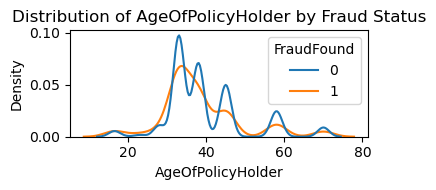

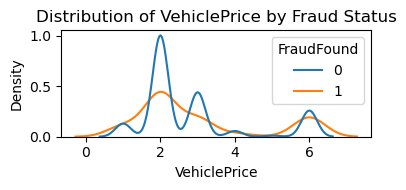

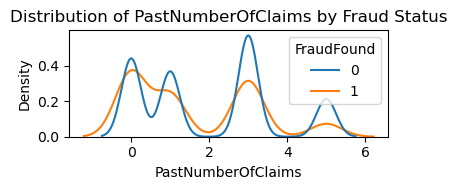

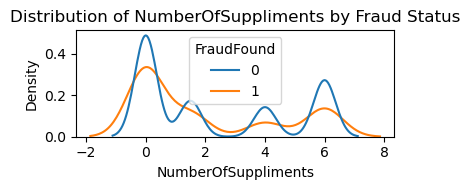

In [223]:
# Density plots
numeric_vars = ['AgeOfPolicyHolder', 'VehiclePrice', 
                'PastNumberOfClaims', 'NumberOfSuppliments']

for col in numeric_vars:
    plt.figure(figsize=(4, 2))
    sns.kdeplot(data=data, x=col, hue='FraudFound', common_norm=False)
    plt.title(f'Distribution of {col} by Fraud Status')
    plt.tight_layout()
    plt.show()

1.	AgeOfPolicyHolder by Fraud Status: Fraudulent claims are slightly more frequent among younger policyholders (around ages 30-40).
2.	VehiclePrice by Fraud Status: Lower vehicle prices (around 1-2) are associated with more fraudulent claims.
3.	PastNumberOfClaims by Fraud Status: Fraud cases tend to peak when the number of past claims is 0 or 3.
4.	NumberOfSuppliments by Fraud Status: Fraud cases are more concentrated around 0 supplements

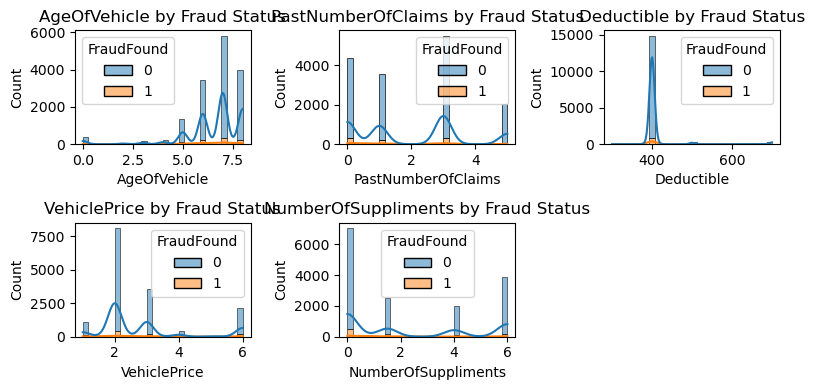

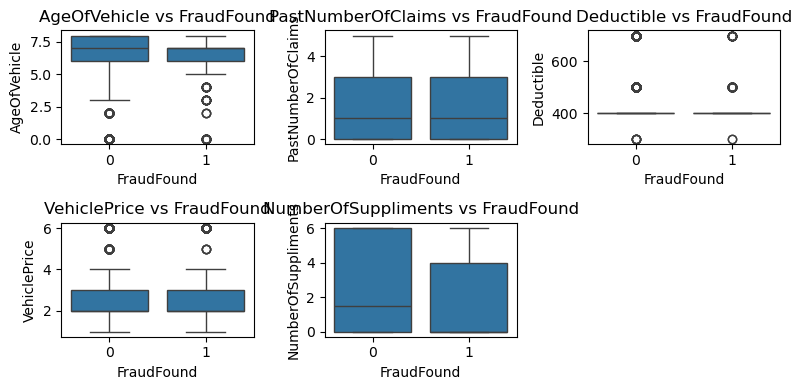

In [225]:
# List of numeric features 
numeric_features = ['AgeOfVehicle', 'PastNumberOfClaims', 'Deductible', 'VehiclePrice', 'NumberOfSuppliments']

# Setting up the plot size
plt.figure(figsize=(8, 4))

# Print histograms 
for i, feature in enumerate(numeric_features, 1):
    plt.subplot(2, 3, i)  # 2 rows, 3 columns
    sns.histplot(data=data, x=feature, hue="FraudFound", multiple="stack", kde=True, bins=30)
    plt.title(f'{feature} by Fraud Status')
    plt.tight_layout()

plt.show()

# Print boxplots
plt.figure(figsize=(8, 4))
for i, feature in enumerate(numeric_features, 1):
    plt.subplot(2, 3, i)  # 2 rows, 3 columns
    sns.boxplot(data=data, x='FraudFound', y=feature)
    plt.title(f'{feature} vs FraudFound')
    plt.tight_layout()

plt.show()

Histograms
1.	AgeOfVehicle by Fraud Status: Fraudulent claims appear more common in older vehicles (around 6-8 years)
2.	PastNumberOfClaims by Fraud Status: Fraudulent claims are more frequent when the number of past claims is 0, 1, or 3.
3.	Deductible by Fraud Status: Most claims, including fraudulent ones, are concentrated around a deductible of 400.
4.	VehiclePrice by Fraud Status: Lower vehicle prices (around 2) show a higher number of fraudulent claims
5.	NumberOfSuppliments by Fraud Status: Fraudulent claims are more prevalent when the number of supplements is 0.

Boxplots
1.	Age of Vehicle: Fraud cases tend to involve slightly newer vehicles.
2.	Past Number of Claims: No differences discovered
3.	Deductible & Vehicle Price: No differences discovered
4.	Number of Supplements: Fraud cases tend to have fewer supplements.

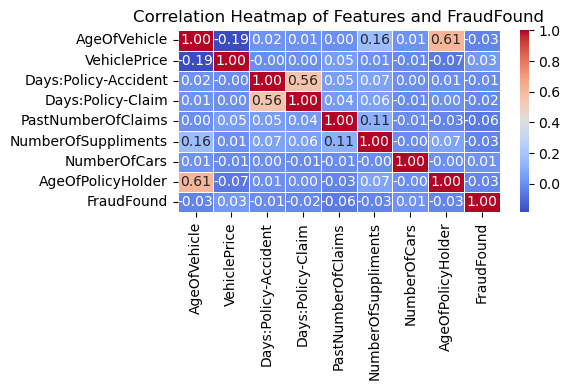

In [227]:
# Heatmap
# Select numeric features for correlation
numeric_features = ['AgeOfVehicle', 'VehiclePrice', 'Days:Policy-Accident', 'Days:Policy-Claim', 
                    'PastNumberOfClaims', 'NumberOfSuppliments', 'NumberOfCars', 'AgeOfPolicyHolder']

# Compute the correlation matrix
corr_matrix = data[numeric_features + ['FraudFound']].corr()

# Plot heatmap
plt.figure(figsize=(6, 4))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title('Correlation Heatmap of Features and FraudFound')
plt.tight_layout()
plt.show()

Strong Relationships: Some features, such as AgeOfVehicle and AgeOfPolicyHolder, exhibit a moderately strong positive correlation (around 0.61). Weak or No Relationships: The feature FraudFound shows very weak correlations with all the other variables, indicating that none of these features, by themselves, have a strong linear relationship with fraud. This could imply that predicting fraud might require more complex interactions or additional features.


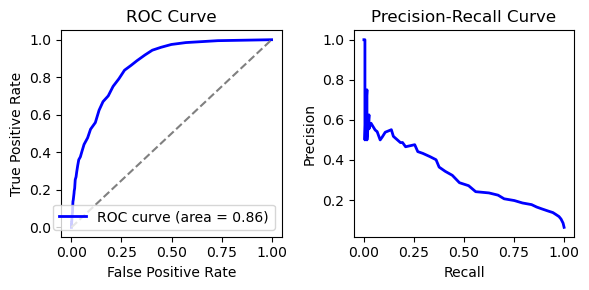

In [229]:
# Split data into features (X) and target (y)
X = data.drop(columns=['FraudFound'])
y = data['FraudFound']

# Encode categorical variables 
X_encoded = pd.get_dummies(X)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.2, random_state=42)

# Train a random forest classifier 
model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)

# Predict probabilities
y_probs = model.predict_proba(X_test)[:, 1]

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_probs)
roc_auc = auc(fpr, tpr)

# Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_test, y_probs)

# Plot ROC and Precision-Recall Curve
plt.figure(figsize=(6, 3))

# ROC Curve
plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')

# Precision-Recall Curve
plt.subplot(1, 2, 2)
plt.plot(recall, precision, color='blue', lw=2)
plt.title('Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')

plt.tight_layout()
plt.show()

In [230]:
# Predict on the test set
y_pred = model.predict(X_test)

# Calculate metrics
precision = precision_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)

print(f"Precision: {precision:.2f}")
print(f"F1-Score: {f1:.2f}")
print("Confusion Matrix:")
print(cm)

Precision: 0.50
F1-Score: 0.01
Confusion Matrix:
[[2886    1]
 [ 196    1]]


The model correctly identifies 50% of the claims it labels as fraud. However, since there are very few positive predictions, this high precision doesn’t mean good performance. The F1-Score being so low indicates that the model rarely detects fraud correctly. 

In [232]:
# Cross-validate with 5 folds
cv_scores = cross_val_score(model, X_encoded, y, cv=5, scoring='f1')
print(f"Cross-Validation F1-Score: {cv_scores.mean():.2f} ± {cv_scores.std():.2f}")

Cross-Validation F1-Score: 0.05 ± 0.09


The cross-validation F1-Score being around 0.05 ± 0.09 confirms that your model's performance is both poor and highly variable across different data splits. This again highlights that the model is struggling to detect fraud consistently.

Although collecting more genuine fraud cases would be ideal, in many real‐world settings, those labels are scarce or unavailable. Simple class weighting boosts recall but can still leave the model starved for minority examples and prone to overfitting on noise. We chose SMOTE to generate new, plausible fraud examples in feature space so the learner sees more variety in the minority class. We acknowledge that SMOTE can introduce artifacts and should not be the sole solution. In production, we recommend ongoing efforts to acquire additional labeled fraud cases or to apply under‐sampling of the majority class rather than depending solely on synthetic data rather

Precision: 1.00
F1-Score: 0.97
Recall: 0.94
Confusion Matrix:
[[2897    2]
 [ 167 2733]]
Cross-Validation F1-Score: 0.90 ± 0.10


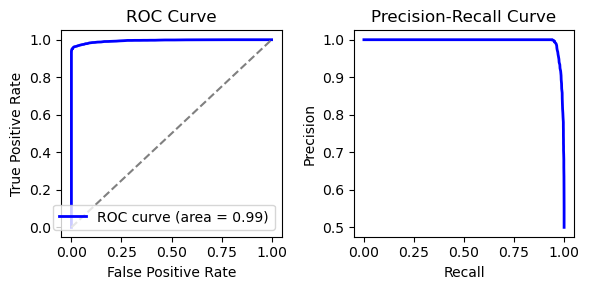

In [235]:
# Split data into features (X) and target (y)
X = data.drop(columns=['FraudFound'])
y = data['FraudFound']

# Encode categorical variables
X_encoded = pd.get_dummies(X)

# Handle class imbalance with SMOTE
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_encoded, y)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

# Train a random forest classifier with class weighting
model = RandomForestClassifier(class_weight='balanced', random_state=42)
model.fit(X_train, y_train)

# Predict probabilities
y_probs = model.predict_proba(X_test)[:, 1]
y_pred = model.predict(X_test)

# Calculate metrics
precision = precision_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)

print(f"Precision: {precision:.2f}")
print(f"F1-Score: {f1:.2f}")
print(f"Recall: {recall:.2f}")
print("Confusion Matrix:")
print(cm)

# Cross-validation with F1-Score
cv_scores = cross_val_score(model, X_resampled, y_resampled, cv=5, scoring='f1')
print(f"Cross-Validation F1-Score: {cv_scores.mean():.2f} ± {cv_scores.std():.2f}")

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_probs)
roc_auc = auc(fpr, tpr)

# Precision-Recall Curve
precision_curve, recall_curve, _ = precision_recall_curve(y_test, y_probs)

# Plot ROC and Precision-Recall Curve
plt.figure(figsize=(6, 3))

# ROC Curve
plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')

# Precision-Recall Curve
plt.subplot(1, 2, 2)
plt.plot(recall_curve, precision_curve, color='blue', lw=2)
plt.title('Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')

plt.tight_layout()
plt.show()

The model correctly identified all instances that it labeled as fraud, achieving perfect precision with no false positives. However, it did not capture all actual fraud cases, identifying 94% of them. The high F1-Score of 0.97 indicates that the model maintains a good balance between precision and recall.

We selected XGBoost because its gradient-boosting framework excels at modeling complex, nonlinear relationships without requiring synthetic data. Its built-in regularization mechanisms, including shrinkage, column subsampling, and tree-specific penalties, help prevent the kind of overfitting we observed with our baseline Random Forest. XGBoost also offers native parameter controls for imbalance rather than relying on external sampling techniques. We performed a grid search over learning rate, maximum tree depth, and subsample ratio to arrive at stable hyperparameters that balance bias and variance.


Precision: 0.99
Recall: 0.96
F1 Score: 0.98
Confusion Matrix:
[[2874   25]
 [ 104 2796]]


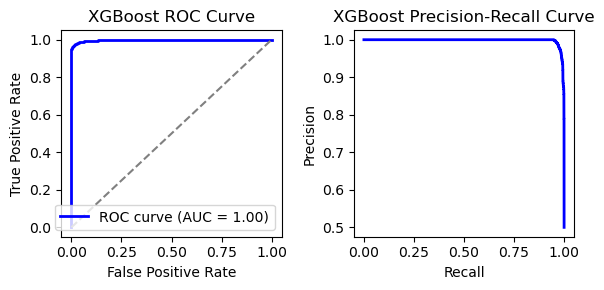

In [238]:
# Instantiate the XGBoost classifier
xgb_model = XGBClassifier(
    random_state=42,
    eval_metric='logloss'     # Use logloss as evaluation metric
)

# Fit the model on the training data
xgb_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = xgb_model.predict(X_test)
y_probs = xgb_model.predict_proba(X_test)[:, 1]

# Evaluate the performance
precision = precision_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)

print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")
print("Confusion Matrix:")
print(cm)

# Plot ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_probs)
roc_auc = auc(fpr, tpr)

# Plot Precision-Recall Curve
precision_curve, recall_curve, _ = precision_recall_curve(y_test, y_probs)

plt.figure(figsize=(6, 3))

# ROC Curve subplot
plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('XGBoost ROC Curve')
plt.legend(loc='lower right')

# Precision-Recall Curve subplot
plt.subplot(1, 2, 2)
plt.plot(recall_curve, precision_curve, color='blue', lw=2)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('XGBoost Precision-Recall Curve')

plt.tight_layout()
plt.show()


The XGBoost model achievs ea precision of 0.99, a recall of 0.96  and an AUC of 1.00 on our test set, demonstrating its strong discrimination and ability to learn without synthetic sampling. However, perfect separation on the test data may signal residual overfitting. To validate real-world performa,c,e we will reserve an out-of-time hold-out set or collect new claims for an additional blind evaluation. We will also compare the business impact of the 25 false positives against the 104 missed frauds to set an appropriate decision threshold. These steps will ensure that the XGBoost model not only performs well in retrospective tests but also generalizes reliably before deployment.



We built a stacking ensemble to leverage the complementary strengths of different algorithms. Logistic regression provides a transparent linear baseline, Random Forest captures complex feature interactions without heavy tuning, and XGBoost excels at modeling nonlinear relationships with built-in regularization. By combining their out-of-fold predictions through a logistic regression meta-learner under five-fold cross-validation, we allow the meta-model to learn which base learner is most reliable in various regions of the feature space. This approach reduces variance compared to any single model and can adapt more flexibly to evolving fraud pattern.


Stacking Ensemble Performance:
Precision: 0.99
Recall: 0.97
F1 Score: 0.98
Confusion Matrix:
[[2868   31]
 [  86 2814]]


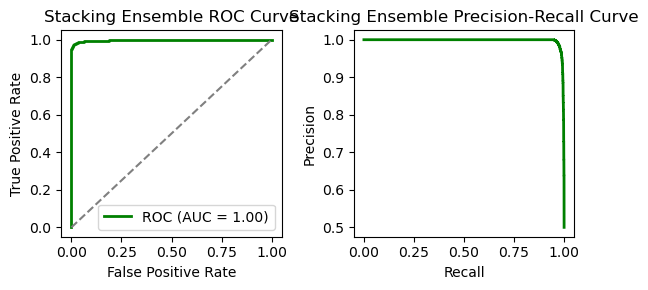

In [241]:
# Stacking Ensemble
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Define base estimators for the stacking ensemble
estimators = [
    ('lr', LogisticRegression(max_iter=2000, random_state=42)),
    ('rf', RandomForestClassifier(n_estimators=100, random_state=42)),
    ('xgb', XGBClassifier(eval_metric='logloss', random_state=42))  # Removed use_label_encoder parameter
]

# Define the stacking classifier with a logistic regression as the final estimator and a higher max_iter
stacking_clf = StackingClassifier(
    estimators=estimators,
    final_estimator=LogisticRegression(max_iter=5000, random_state=42),
    cv=5
)

# Fit the stacking classifier on your (scaled) training data
stacking_clf.fit(X_train_scaled, y_train)

# Obtain predictions and probabilities on the (scaled) test set
y_pred_stack = stacking_clf.predict(X_test_scaled)
y_probs_stack = stacking_clf.predict_proba(X_test_scaled)[:, 1]

# Evaluate performance as before...
precision_stack = precision_score(y_test, y_pred_stack)
recall_stack = recall_score(y_test, y_pred_stack)
f1_stack = f1_score(y_test, y_pred_stack)
cm_stack = confusion_matrix(y_test, y_pred_stack)

print("Stacking Ensemble Performance:")
print(f"Precision: {precision_stack:.2f}")
print(f"Recall: {recall_stack:.2f}")
print(f"F1 Score: {f1_stack:.2f}")
print("Confusion Matrix:")
print(cm_stack)

# Plot ROC and Precision-Recall Curves
fpr_stack, tpr_stack, _ = roc_curve(y_test, y_probs_stack)
roc_auc_stack = auc(fpr_stack, tpr_stack)
precision_curve_stack, recall_curve_stack, _ = precision_recall_curve(y_test, y_probs_stack)

import matplotlib.pyplot as plt
plt.figure(figsize=(6, 3))

plt.subplot(1, 2, 1)
plt.plot(fpr_stack, tpr_stack, color='green', lw=2, label=f'ROC (AUC = {roc_auc_stack:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Stacking Ensemble ROC Curve')
plt.legend(loc='lower right')

plt.subplot(1, 2, 2)
plt.plot(recall_curve_stack, precision_curve_stack, color='green', lw=2)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Stacking Ensemble Precision-Recall Curve')

plt.tight_layout()
plt.show()


The stacking ensemble achieved precision of 0.99, recall of 0.,97 and an AUC of 1.00 on the test set, matching XGBoost in overall discrimination while slightly improving recall consistency. Its confusion matrix showed 31 false positives and 86 false negatives, reflecting robust error trade-offs across fraud and non-fraud cases. Despite these strong retrospective results, we will validate on a separate hold-out cohort or newly collected claims to guard against subtle overfitting. We will also compare the cost implications of the remaining false positives and negatives and adjust our meta-learner’s decision threshold accordingly. These steps will ensure that our ensemble maintains its performance in production and continues to deliver reliable, business-aligned fraud detectio 
